**Neural Network Training**

Train a neural network classifier on top of Sentence-BERT embeddings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import os
if os.path.exists('product_embeddings.npy'):
       os.remove('product_embeddings.npy')
if os.path.exists('query_embeddings_train.npy'):
       os.remove('query_embeddings_train.npy')
if os.path.exists('query_embeddings_val.npy'):
       os.remove('query_embeddings_val.npy')
if os.path.exists('query_embeddings_test.npy'):
       os.remove('query_embeddings_test.npy')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Using device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

Mounted at /content/drive
STEP 6: NEURAL NETWORK TRAINING

🖥️  Using device: cuda
   GPU: NVIDIA A100-SXM4-40GB


**Hyperparameters**

In [ ]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5
RANDOM_SEED = 42

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"\n  Hyperparameters:")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Max Epochs: {NUM_EPOCHS}")
print(f"   Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")


⚙️  Hyperparameters:
   Batch Size: 64
   Learning Rate: 0.001
   Max Epochs: 20
   Early Stopping Patience: 5


**Load Data**

In [ ]:
# Load products
products_df = pd.read_csv('/content/drive/MyDrive/cosmetic_p.csv')
print(f"Loaded {len(products_df)} products")

# Load training pairs
train_df = pd.read_csv('/content/drive/MyDrive/training_pairs_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/training_pairs_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/training_pairs_test.csv')

print(f"Loaded training data:")
print(f"   Train: {len(train_df):,} pairs ({(train_df['label']==1).sum():,} positive)")
print(f"   Val:   {len(val_df):,} pairs ({(val_df['label']==1).sum():,} positive)")
print(f"   Test:  {len(test_df):,} pairs ({(test_df['label']==1).sum():,} positive)")


LOADING DATA
✓ Loaded 1472 products
✓ Loaded training data:
   Train: 59,670 pairs (19,890 positive)
   Val:   12,780 pairs (4,260 positive)
   Test:  12,825 pairs (4,275 positive)


**Generate Sentence-Bert Embeddings**

In [ ]:
print("\nLoading Sentence-BERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded: all-MiniLM-L6-v2 (384-dim embeddings)")

# Check if embeddings already exist
import os
if os.path.exists('product_embeddings.npy') and os.path.exists('query_embeddings_train.npy'):
    print("\nFound existing embeddings, loading...")
    product_embeddings = np.load('product_embeddings.npy')
    query_embeddings_train = np.load('query_embeddings_train.npy')
    query_embeddings_val = np.load('query_embeddings_val.npy')
    query_embeddings_test = np.load('query_embeddings_test.npy')
    print("Loaded embeddings from files")
else:
    print("\nGenerating embeddings (this may take 5-10 minutes)...")

    # Encode all products
    print("\n   Encoding products...")
    product_texts = products_df['ingredients'].fillna('').tolist()
    product_embeddings = sbert_model.encode(
        product_texts,
        show_progress_bar=True,
        batch_size=32,
        normalize_embeddings=True
    )

    # Encode unique queries from each split
    print("\n   Encoding train queries...")
    train_queries = train_df['query'].unique()
    query_embeddings_train = sbert_model.encode(
        train_queries.tolist(),
        show_progress_bar=True,
        batch_size=32,
        normalize_embeddings=True
    )

    print("\n   Encoding val queries...")
    val_queries = val_df['query'].unique()
    query_embeddings_val = sbert_model.encode(
        val_queries.tolist(),
        show_progress_bar=True,
        batch_size=32,
        normalize_embeddings=True
    )

    print("\n   Encoding test queries...")
    test_queries = test_df['query'].unique()
    query_embeddings_test = sbert_model.encode(
        test_queries.tolist(),
        show_progress_bar=True,
        batch_size=32,
        normalize_embeddings=True
    )

    # Save embeddings
    np.save('product_embeddings.npy', product_embeddings)
    np.save('query_embeddings_train.npy', query_embeddings_train)
    np.save('query_embeddings_val.npy', query_embeddings_val)
    np.save('query_embeddings_test.npy', query_embeddings_test)
    print("\nSaved embeddings to .npy files")

print(f"\nEmbeddings ready:")
print(f"   Product embeddings: {product_embeddings.shape}")
print(f"   Query embeddings (train): {query_embeddings_train.shape}")
print(f"   Query embeddings (val): {query_embeddings_val.shape}")
print(f"   Query embeddings (test): {query_embeddings_test.shape}")

# Create query-to-embedding mapping
train_query_to_emb = dict(zip(train_df['query'].unique(), query_embeddings_train))
val_query_to_emb = dict(zip(val_df['query'].unique(), query_embeddings_val))
test_query_to_emb = dict(zip(test_df['query'].unique(), query_embeddings_test))


GENERATING SENTENCE-BERT EMBEDDINGS

🤖 Loading Sentence-BERT model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Model loaded: all-MiniLM-L6-v2 (384-dim embeddings)

📝 Generating embeddings (this may take 5-10 minutes)...

   Encoding products...


Batches:   0%|          | 0/46 [00:00<?, ?it/s]


   Encoding train queries...


Batches:   0%|          | 0/42 [00:00<?, ?it/s]


   Encoding val queries...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]


   Encoding test queries...


Batches:   0%|          | 0/9 [00:00<?, ?it/s]


💾 Saved embeddings to .npy files

✓ Embeddings ready:
   Product embeddings: (1472, 384)
   Query embeddings (train): (1326, 384)
   Query embeddings (val): (284, 384)
   Query embeddings (test): (285, 384)


**Prepare Numerical Features**

In [ ]:
# Normalize price and rank
scaler = StandardScaler()
price_rank_features = scaler.fit_transform(
    products_df[['price', 'rank']].fillna(0)
)

print(f"Normalized price and rank features: {price_rank_features.shape}")


PREPARING NUMERICAL FEATURES
✓ Normalized price and rank features: (1472, 2)


PyTorch Dataseta

In [ ]:
class SkincareDataset(Dataset):
    def __init__(self, df, query_to_emb, product_embeddings, price_rank_features):
        self.df = df.reset_index(drop=True)
        self.query_to_emb = query_to_emb
        self.product_embeddings = product_embeddings
        self.price_rank_features = price_rank_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Get query embedding
        query_emb = self.query_to_emb[row['query']]

        # Get product embedding
        product_emb = self.product_embeddings[row['product_id']]

        # Get numerical features
        numerical = self.price_rank_features[row['product_id']]

        # Concatenate all features
        features = np.concatenate([query_emb, product_emb, numerical])

        # Label
        label = float(row['label'])

        return torch.FloatTensor(features), torch.FloatTensor([label])

# Create datasets
print("\nCreating PyTorch datasets...")
train_dataset = SkincareDataset(train_df, train_query_to_emb, product_embeddings, price_rank_features)
val_dataset = SkincareDataset(val_df, val_query_to_emb, product_embeddings, price_rank_features)
test_dataset = SkincareDataset(test_df, test_query_to_emb, product_embeddings, price_rank_features)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created dataloaders:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")


📦 Creating PyTorch datasets...
✓ Created dataloaders:
   Train batches: 933
   Val batches:   200
   Test batches:  201


**Neural Network Model**

In [ ]:
class SkincareMatchingNetwork(nn.Module):
    def __init__(self, input_dim=770):  # 384 + 384 + 2 = 770
        super(SkincareMatchingNetwork, self).__init__()

        self.network = nn.Sequential(
            # Layer 1
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            # Layer 2
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            # Layer 3
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),

            # Output layer
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Initialize model
model = SkincareMatchingNetwork().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MODEL ARCHITECTURE")
print(f"\n{model}\n")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)



MODEL ARCHITECTURE

SkincareMatchingNetwork(
  (network): Sequential(
    (0): Linear(in_features=770, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=64, out_features=1, bias=True)
    (12): Sigmoid()
  )
)

Total parameters: 239,361
Trainable parameters: 239,361


**Training Functions**

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for features, labels in tqdm(loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions
        all_preds.extend((outputs > 0.5).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for features, labels in tqdm(loader, desc="Evaluating", leave=False):
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            all_probs.extend(outputs.cpu().numpy())
            all_preds.extend((outputs > 0.5).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)

    # Calculate metrics
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()
    all_probs = np.array(all_probs).flatten()

    accuracy = np.mean(all_preds == all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0

    return avg_loss, accuracy, precision, recall, f1, auc

**Training Loop**

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': [],
    'val_auc': []
}

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"\nStarting training for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_prec, val_rec, val_f1, val_auc = evaluate(
        model, val_loader, criterion, device
    )

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_precision'].append(val_prec)
    history['val_recall'].append(val_rec)
    history['val_f1'].append(val_f1)
    history['val_auc'].append(val_auc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"Val Prec:   {val_prec:.4f} | Val Rec:   {val_rec:.4f} | Val F1: {val_f1:.4f}")
    print(f"Val AUC:    {val_auc:.4f}")

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print("New best model saved!")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    print()

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load best model
model.load_state_dict(best_model_state)
print("\nLoaded best model from training")

# Save model
torch.save(model.state_dict(), 'skincare_model.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': epoch+1
    }
}, 'skincare_model_full.pth')

print("Saved model to:")
print("   - skincare_model.pth (weights only)")
print("   - skincare_model_full.pth (full checkpoint)")


TRAINING

🚀 Starting training for 20 epochs...

Epoch 1/20
------------------------------------------------------------


Train Loss: 0.1464 | Train Acc: 0.9413
Val Loss:   0.0704 | Val Acc:   0.9760
Val Prec:   0.9499 | Val Rec:   0.9796 | Val F1: 0.9645
Val AUC:    0.9960
✓ New best model saved!

Epoch 2/20
------------------------------------------------------------


Train Loss: 0.0685 | Train Acc: 0.9773
Val Loss:   0.0429 | Val Acc:   0.9858
Val Prec:   0.9696 | Val Rec:   0.9883 | Val F1: 0.9788
Val AUC:    0.9980
✓ New best model saved!

Epoch 3/20
------------------------------------------------------------


Train Loss: 0.0595 | Train Acc: 0.9798
Val Loss:   0.0448 | Val Acc:   0.9850
Val Prec:   0.9640 | Val Rec:   0.9920 | Val F1: 0.9778
Val AUC:    0.9982
⚠️  No improvement (1/5)

Epoch 4/20
------------------------------------------------------------


Train Loss: 0.0518 | Train Acc: 0.9826
Val Loss:   0.0310 | Val Acc:   0.9900
Val Prec:   0.9754 | Val Rec:   0.9951 | Val F1: 0.9851
Val AUC:    0.9989
✓ New best model saved!

Epoch 5/20
------------------------------------------------------------


Train Loss: 0.0430 | Train Acc: 0.9859
Val Loss:   0.0333 | Val Acc:   0.9895
Val Prec:   0.9723 | Val Rec:   0.9969 | Val F1: 0.9845
Val AUC:    0.9988
⚠️  No improvement (1/5)

Epoch 6/20
------------------------------------------------------------


Train Loss: 0.0410 | Train Acc: 0.9864
Val Loss:   0.0290 | Val Acc:   0.9907
Val Prec:   0.9783 | Val Rec:   0.9941 | Val F1: 0.9861
Val AUC:    0.9990
✓ New best model saved!

Epoch 7/20
------------------------------------------------------------


Train Loss: 0.0348 | Train Acc: 0.9887
Val Loss:   0.0284 | Val Acc:   0.9917
Val Prec:   0.9790 | Val Rec:   0.9965 | Val F1: 0.9877
Val AUC:    0.9990
✓ New best model saved!

Epoch 8/20
------------------------------------------------------------


Train Loss: 0.0350 | Train Acc: 0.9887
Val Loss:   0.0355 | Val Acc:   0.9903
Val Prec:   0.9745 | Val Rec:   0.9969 | Val F1: 0.9856
Val AUC:    0.9987
⚠️  No improvement (1/5)

Epoch 9/20
------------------------------------------------------------


Train Loss: 0.0323 | Train Acc: 0.9897
Val Loss:   0.0267 | Val Acc:   0.9926
Val Prec:   0.9808 | Val Rec:   0.9974 | Val F1: 0.9891
Val AUC:    0.9991
✓ New best model saved!

Epoch 10/20
------------------------------------------------------------


Train Loss: 0.0307 | Train Acc: 0.9900
Val Loss:   0.0255 | Val Acc:   0.9925
Val Prec:   0.9804 | Val Rec:   0.9974 | Val F1: 0.9888
Val AUC:    0.9992
✓ New best model saved!

Epoch 11/20
------------------------------------------------------------


Train Loss: 0.0302 | Train Acc: 0.9900
Val Loss:   0.0212 | Val Acc:   0.9935
Val Prec:   0.9836 | Val Rec:   0.9972 | Val F1: 0.9903
Val AUC:    0.9995
✓ New best model saved!

Epoch 12/20
------------------------------------------------------------


Train Loss: 0.0272 | Train Acc: 0.9907
Val Loss:   0.0279 | Val Acc:   0.9922
Val Prec:   0.9804 | Val Rec:   0.9965 | Val F1: 0.9884
Val AUC:    0.9991
⚠️  No improvement (1/5)

Epoch 13/20
------------------------------------------------------------


Train Loss: 0.0254 | Train Acc: 0.9917
Val Loss:   0.0271 | Val Acc:   0.9926
Val Prec:   0.9802 | Val Rec:   0.9979 | Val F1: 0.9889
Val AUC:    0.9992
⚠️  No improvement (2/5)

Epoch 14/20
------------------------------------------------------------


Train Loss: 0.0258 | Train Acc: 0.9919
Val Loss:   0.0234 | Val Acc:   0.9941
Val Prec:   0.9843 | Val Rec:   0.9981 | Val F1: 0.9911
Val AUC:    0.9993
⚠️  No improvement (3/5)

Epoch 15/20
------------------------------------------------------------


Train Loss: 0.0242 | Train Acc: 0.9919
Val Loss:   0.0230 | Val Acc:   0.9937
Val Prec:   0.9847 | Val Rec:   0.9965 | Val F1: 0.9905
Val AUC:    0.9993
⚠️  No improvement (4/5)

Epoch 16/20
------------------------------------------------------------


Train Loss: 0.0170 | Train Acc: 0.9943
Val Loss:   0.0218 | Val Acc:   0.9944
Val Prec:   0.9856 | Val Rec:   0.9979 | Val F1: 0.9917
Val AUC:    0.9995
⚠️  No improvement (5/5)

🛑 Early stopping triggered after 16 epochs

✓ Loaded best model from training
💾 Saved model to:
   - skincare_model.pth (weights only)
   - skincare_model_full.pth (full checkpoint)


**Test Set Evaluation**

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_f1, test_auc = evaluate(
    model, test_loader, criterion, device
)

print(f"\nTest Set Results:")
print(f"   Loss:      {test_loss:.4f}")
print(f"   Accuracy:  {test_acc:.4f}")
print(f"   Precision: {test_prec:.4f}")
print(f"   Recall:    {test_rec:.4f}")
print(f"   F1 Score:  {test_f1:.4f}")
print(f"   AUC-ROC:   {test_auc:.4f}")


TEST SET EVALUATION



📊 Test Set Results:
   Loss:      0.0181
   Accuracy:  0.9949
   Precision: 0.9866
   Recall:    0.9984
   F1 Score:  0.9924
   AUC-ROC:   0.9996


Visualizations


📊 Creating visualizations...


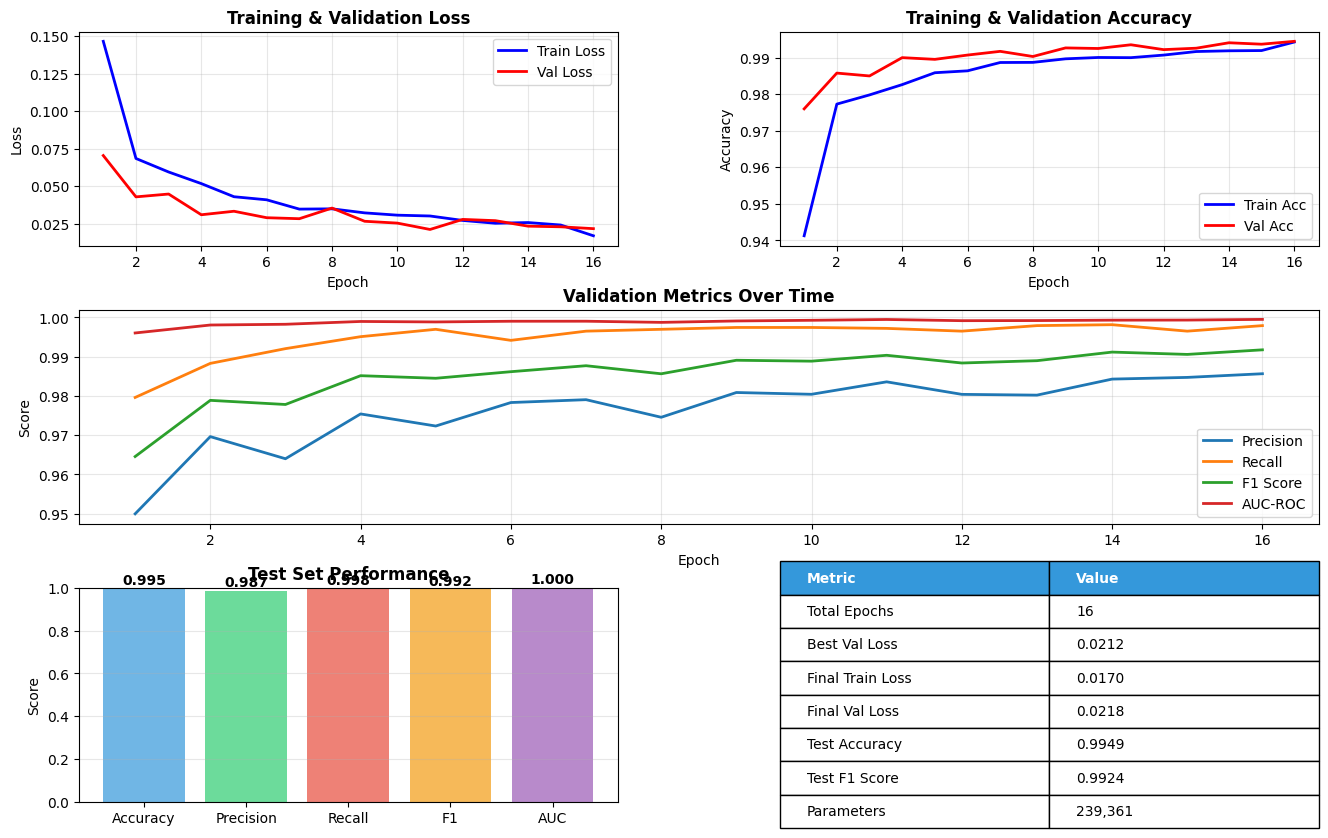

💾 Saved: training_results.png


In [ ]:
print("\nCreating visualizations...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Training & Validation Loss
ax1 = fig.add_subplot(gs[0, 0])
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training & Validation Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Validation Metrics Over Time
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(epochs_range, history['val_precision'], label='Precision', linewidth=2)
ax3.plot(epochs_range, history['val_recall'], label='Recall', linewidth=2)
ax3.plot(epochs_range, history['val_f1'], label='F1 Score', linewidth=2)
ax3.plot(epochs_range, history['val_auc'], label='AUC-ROC', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Score')
ax3.set_title('Validation Metrics Over Time', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Final Test Metrics Bar Chart
ax4 = fig.add_subplot(gs[2, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
values = [test_acc, test_prec, test_rec, test_f1, test_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']
bars = ax4.bar(metrics, values, color=colors, alpha=0.7)
ax4.set_ylabel('Score')
ax4.set_title('Test Set Performance', fontweight='bold')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{val:.3f}', ha='center', fontweight='bold')

# 5. Training Summary Table
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Total Epochs', f"{len(history['train_loss'])}"],
    ['Best Val Loss', f"{best_val_loss:.4f}"],
    ['Final Train Loss', f"{history['train_loss'][-1]:.4f}"],
    ['Final Val Loss', f"{history['val_loss'][-1]:.4f}"],
    ['Test Accuracy', f"{test_acc:.4f}"],
    ['Test F1 Score', f"{test_f1:.4f}"],
    ['Parameters', f"{trainable_params:,}"]
]
table = ax5.table(cellText=summary_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(summary_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#3498db')
        table[(i, 1)].set_facecolor('#3498db')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')

plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: training_results.png")

**Summary**

In [ ]:
print(f"""
FINAL RESULTS:

Training:
  • Epochs trained: {len(history['train_loss'])}
  • Best val loss: {best_val_loss:.4f}
  • Final train loss: {history['train_loss'][-1]:.4f}
  • Final train acc: {history['train_acc'][-1]:.4f}

Test Performance:
  • Accuracy:  {test_acc:.4f}
  • Precision: {test_prec:.4f}
  • Recall:    {test_rec:.4f}
  • F1 Score:  {test_f1:.4f}
  • AUC-ROC:   {test_auc:.4f}

Model:
  • Architecture: 4-layer neural network
  • Parameters: {trainable_params:,}
  • Input: Sentence-BERT embeddings (384×2) + numerical (2)
  • Output: Binary compatibility score

Files Created:
  • skincare_model.pth - Model weights
  • skincare_model_full.pth - Full checkpoint
  • product_embeddings.npy - Product embeddings
  • query_embeddings_*.npy - Query embeddings
  • training_results.png - Visualizations
""")


✅ TRAINING COMPLETE!

📊 FINAL RESULTS:

Training:
  • Epochs trained: 16
  • Best val loss: 0.0212
  • Final train loss: 0.0170
  • Final train acc: 0.9943

Test Performance:
  • Accuracy:  0.9949
  • Precision: 0.9866
  • Recall:    0.9984
  • F1 Score:  0.9924
  • AUC-ROC:   0.9996

Model:
  • Architecture: 4-layer neural network
  • Parameters: 239,361
  • Input: Sentence-BERT embeddings (384×2) + numerical (2)
  • Output: Binary compatibility score

📁 Files Created:
  • skincare_model.pth - Model weights
  • skincare_model_full.pth - Full checkpoint
  • product_embeddings.npy - Product embeddings
  • query_embeddings_*.npy - Query embeddings
  • training_results.png - Visualizations

🎯 NEXT STEPS:
  1. Build baseline model (Sentence-BERT + cosine similarity)
  2. Compare baseline vs neural network
  3. Calculate Precision@K and MRR for both
  4. Conduct user study with best model

Your neural network is trained and ready! 🚀






---


**Interactive Demo**

---



In [ ]:
import warnings
warnings.filterwarnings('ignore')

INTERACTIVE SKINCARE RECOMMENDATION DEMO


**Load Model and Data**

In [ ]:
print("\nLoading model and data...")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load products
products_df = pd.read_csv('/content/drive/MyDrive/cosmetic_p.csv')

# Load embeddings
product_embeddings = np.load('product_embeddings.npy')
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare scaler for numerical features
scaler = StandardScaler()
price_rank_features = scaler.fit_transform(
    products_df[['price', 'rank']].fillna(0)
)

# Define model architecture
class SkincareMatchingNetwork(nn.Module):
    def __init__(self, input_dim=770):
        super(SkincareMatchingNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

# Load trained model
model = SkincareMatchingNetwork().to(device)
model.load_state_dict(torch.load('skincare_model.pth', map_location=device))
model.eval()

print("Model loaded successfully")
print(f"Loaded {len(products_df)} products")
print(f"Using device: {device}")


📂 Loading model and data...
✓ Model loaded successfully
✓ Loaded 1472 products
✓ Using device: cuda


Recommendation Functions

In [ ]:
def get_compatibility_scores(query):
    """
    Get compatibility scores for all products given a query.
    Returns: array of scores (one per product)
    """
    # Encode query
    query_emb = sbert_model.encode([query], normalize_embeddings=True)[0]

    # Prepare features for all products
    batch_features = []
    for i in range(len(products_df)):
        product_emb = product_embeddings[i]
        numerical = price_rank_features[i]
        features = np.concatenate([query_emb, product_emb, numerical])
        batch_features.append(features)

    # Convert to tensor
    batch_tensor = torch.FloatTensor(np.array(batch_features)).to(device)

    # Get predictions
    with torch.no_grad():
        scores = model(batch_tensor).cpu().numpy().flatten()

    return scores

def recommend_top_k(query, k=5):
    """
    Recommend top-K products for a query.
    """
    scores = get_compatibility_scores(query)

    # Get top K indices
    top_indices = scores.argsort()[-k:][::-1]

    # Build results
    results = []
    for idx in top_indices:
        results.append({
            'rank': len(results) + 1,
            'name': products_df.iloc[idx]['name'],
            'brand': products_df.iloc[idx]['brand'],
            'category': products_df.iloc[idx]['Label'],
            'price': products_df.iloc[idx]['price'],
            'rating': products_df.iloc[idx]['rank'],
            'compatibility_score': scores[idx],
            'skin_types': ', '.join([
                st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
                if products_df.iloc[idx][st] == 1
            ])
        })

    return results

def recommend_routine(query):
    """
    Build a complete skincare routine (one product per category).
    """
    scores = get_compatibility_scores(query)

    # Define routine categories in order
    routine_categories = [
        'Cleanser',
        'Treatment',
        'Eye cream',
        'Moisturizer',
        'Sun protect',
        'Face Mask'
    ]

    routine = {}

    for category in routine_categories:
        # Filter products by category
        category_mask = products_df['Label'] == category
        category_indices = products_df[category_mask].index.tolist()

        if len(category_indices) == 0:
            continue

        # Get scores for this category
        category_scores = scores[category_indices]

        # Get best product
        best_local_idx = category_scores.argmax()
        best_global_idx = category_indices[best_local_idx]

        routine[category] = {
            'name': products_df.iloc[best_global_idx]['name'],
            'brand': products_df.iloc[best_global_idx]['brand'],
            'price': products_df.iloc[best_global_idx]['price'],
            'rating': products_df.iloc[best_global_idx]['rank'],
            'compatibility_score': scores[best_global_idx],
            'skin_types': ', '.join([
                st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
                if products_df.iloc[best_global_idx][st] == 1
            ])
        }

    return routine

**Interactive Demo**

In [ ]:
def display_top_k_results(results, query):
    """Display top-K recommendations in a nice format."""
    print(f"\n{'='*80}")
    print(f"QUERY: '{query}'")
    print(f"{'='*80}\n")
    print(f"TOP {len(results)} RECOMMENDATIONS:\n")

    for r in results:
        print(f"#{r['rank']}. {r['name']}")
        print(f"    Brand:        {r['brand']}")
        print(f"    Category:     {r['category']}")
        print(f"    Price:        ${r['price']:.2f}")
        print(f"    Rating:       {r['rating']:.1f}/5.0")
        print(f"    Match Score:  {r['compatibility_score']:.1%} ")
        print(f"    For:          {r['skin_types']}")
        print()

def display_routine(routine, query):
    """Display routine recommendations in a nice format."""
    print(f"\n{'='*80}")
    print(f"QUERY: '{query}'")
    print(f"{'='*80}\n")
    print(f"YOUR PERSONALIZED SKINCARE ROUTINE \n")

    step = 1
    for category, product in routine.items():
        print(f"STEP {step}: {category.upper()}")
        print(f"  -> {product['name']}")
        print(f"     By {product['brand']} | ${product['price']:.2f} |  {product['rating']:.1f}")
        print(f"     Match: {product['compatibility_score']:.1%} | For: {product['skin_types']}")
        print()
        step += 1

    total_cost = sum(p['price'] for p in routine.values())
    avg_score = np.mean([p['compatibility_score'] for p in routine.values()])
    print(f"{'='*80}")
    print(f" Total Routine Cost: ${total_cost:.2f}")
    print(f" Average Compatibility: {avg_score:.1%}")
    print(f"{'='*80}")

**Test Queries**

In [ ]:
print("DEMO: TESTING WITH SAMPLE QUERIES")

# Sample queries
test_queries = [
    "I have dry sensitive skin with redness",
    "oily skin with acne and large pores",
    "anti aging products for mature skin",
    "combination skin with occasional breakouts"
]

# Mode 1: Top-K Recommendations
print("\n" + "="*80)
print("MODE 1: TOP-K RECOMMENDATIONS")
print("="*80)

for query in test_queries[:2]:  # Show 2 examples
    results = recommend_top_k(query, k=5)
    display_top_k_results(results, query)
    input("Press Enter to continue...")

# Mode 2: Full Routine
print("MODE 2: FULL SKINCARE ROUTINE")

for query in test_queries[2:3]:  # Show 1 example
    routine = recommend_routine(query)
    display_routine(routine, query)
    input("Press Enter to continue...")


DEMO: TESTING WITH SAMPLE QUERIES

MODE 1: TOP-K RECOMMENDATIONS

🔍 QUERY: 'I have dry sensitive skin with redness'

📋 TOP 5 RECOMMENDATIONS:

#1. Beauty Water
    Brand:        SON & PARK
    Category:     Moisturizer
    Price:        $30.00
    Rating:       4.6/5.0
    Match Score:  100.0% ✨
    For:          Dry, Oily, Combination, Normal, Sensitive

#2. Miracle Water 3-in-1 Micellar Cleanser
    Brand:        IT COSMETICS
    Category:     Moisturizer
    Price:        $38.00
    Rating:       4.5/5.0
    Match Score:  100.0% ✨
    For:          Dry, Oily, Combination, Normal, Sensitive

#3. Your Skin But Better™ CC+™ Cream with SPF 50+
    Brand:        IT COSMETICS
    Category:     Moisturizer
    Price:        $38.00
    Rating:       4.1/5.0
    Match Score:  100.0% ✨
    For:          Dry, Oily, Combination, Normal, Sensitive

#4. Your Skin But Better™ CC+Illumination™ Cream with SPF 50+
    Brand:        IT COSMETICS
    Category:     Moisturizer
    Price:        $38.00


**Interactive Mode**

In [ ]:
print("INTERACTIVE MODE - you can try your own queries")

def interactive_session():
    print("\nYou can now test the model with your own queries!")
    print("Commands:")
    print("  - Type a skincare concern (e.g., 'dry skin with acne')")
    print("  - Type 'routine' before your query for a full routine")
    print("  - Type 'quit' to exit")
    print()

    while True:
        user_input = input("🔍 Enter query (or 'quit'): ").strip()

        if user_input.lower() == 'quit':
            print("\n Thanks for using the demo!")
            break

        if not user_input:
            continue

        # Check if user wants routine
        if user_input.lower().startswith('routine'):
            query = user_input[7:].strip()
            if not query:
                query = input("   Enter your skin concerns: ").strip()
            routine = recommend_routine(query)
            display_routine(routine, query)
        else:
            query = user_input
            k = 5
            results = recommend_top_k(query, k=k)
            display_top_k_results(results, query)

        print()

# Start interactive mode
interactive_session()


💡 INTERACTIVE MODE - TRY YOUR OWN QUERIES!

You can now test the model with your own queries!
Commands:
  - Type a skincare concern (e.g., 'dry skin with acne')
  - Type 'routine' before your query for a full routine
  - Type 'quit' to exit

🔍 Enter query (or 'quit'): quit

👋 Thanks for using the demo!


 Diagnose current model to confirm what's actually wrong before making changes

In [ ]:
print("🔍 MODEL DIAGNOSTICS - CHECKING FOR ISSUES")

model.eval()
all_scores = []

# Test on a few different queries
test_queries = [
    "dry sensitive skin",
    "oily acne prone",
    "anti aging wrinkles",
    "combination skin"
]

print("\nGetting scores for different queries...\n")
for query in test_queries:
    query_emb = sbert_model.encode([query], normalize_embeddings=True)[0]

    # Get scores for all products
    batch_features = []
    for i in range(len(products_df)):
        product_emb = product_embeddings[i]
        numerical = price_rank_features[i]
        features = np.concatenate([query_emb, product_emb, numerical])
        batch_features.append(features)

    batch_tensor = torch.FloatTensor(np.array(batch_features)).to(device)

    with torch.no_grad():
        scores = model(batch_tensor).cpu().numpy().flatten()

    all_scores.extend(scores)

    print(f"Query: '{query}'")
    print(f"  Min: {scores.min():.4f} | Max: {scores.max():.4f} | Mean: {scores.mean():.4f} | Std: {scores.std():.4f}")
    print(f"  Scores > 0.9: {(scores > 0.9).sum()}/{len(scores)}")

all_scores = np.array(all_scores)

print("OVERALL SCORE DISTRIBUTION:")
print(f"Min:     {all_scores.min():.6f}")
print(f"Max:     {all_scores.max():.6f}")
print(f"Mean:    {all_scores.mean():.6f}")
print(f"Std Dev: {all_scores.std():.6f}")
print(f"\nScores in ranges:")
print(f"  [0.0-0.2]: {(all_scores < 0.2).sum():,} ({(all_scores < 0.2).sum()/len(all_scores)*100:.1f}%)")
print(f"  [0.2-0.4]: {((all_scores >= 0.2) & (all_scores < 0.4)).sum():,} ({((all_scores >= 0.2) & (all_scores < 0.4)).sum()/len(all_scores)*100:.1f}%)")
print(f"  [0.4-0.6]: {((all_scores >= 0.4) & (all_scores < 0.6)).sum():,} ({((all_scores >= 0.4) & (all_scores < 0.6)).sum()/len(all_scores)*100:.1f}%)")
print(f"  [0.6-0.8]: {((all_scores >= 0.6) & (all_scores < 0.8)).sum():,} ({((all_scores >= 0.6) & (all_scores < 0.8)).sum()/len(all_scores)*100:.1f}%)")
print(f"  [0.8-1.0]: {(all_scores >= 0.8).sum():,} ({(all_scores >= 0.8).sum()/len(all_scores)*100:.1f}%)")

if all_scores.std() < 0.01:
    print(f"\n PROBLEM CONFIRMED: Model is saturated!")
    print(f"   All predictions are nearly identical (std = {all_scores.std():.6f})")
    print(f"\n   Root cause: Training data likely has too many positive examples")
elif all_scores.std() < 0.1:
    print(f"\n  WARNING: Low variance in predictions (std = {all_scores.std():.4f})")
    print(f"   Model may not be discriminating well between products")
else:
    print(f"\n Model variance looks reasonable (std = {all_scores.std():.4f})")

# Also check training data balance
print("TRAINING DATA BALANCE CHECK:")
print(f"Positive samples: {(train_df['label']==1).sum():,} ({(train_df['label']==1).sum()/len(train_df)*100:.1f}%)")
print(f"Negative samples: {(train_df['label']==0).sum():,} ({(train_df['label']==0).sum()/len(train_df)*100:.1f}%)")

if (train_df['label']==1).sum() / len(train_df) > 0.7:
    print(f"\n PROBLEM: Training data is heavily imbalanced toward positives!")
    print(f"   This causes the model to predict 'match' for everything")


🔍 MODEL DIAGNOSTICS - CHECKING FOR ISSUES

Getting scores for different queries...

Query: 'dry sensitive skin'
  Min: 0.0000 | Max: 1.0000 | Mean: 0.0922 | Std: 0.2736
  Scores > 0.9: 108/1472
Query: 'oily acne prone'
  Min: 0.0000 | Max: 1.0000 | Mean: 0.0574 | Std: 0.2183
  Scores > 0.9: 65/1472
Query: 'anti aging wrinkles'
  Min: 0.0000 | Max: 1.0000 | Mean: 0.0690 | Std: 0.2386
  Scores > 0.9: 80/1472
Query: 'combination skin'
  Min: 0.0000 | Max: 1.0000 | Mean: 0.0906 | Std: 0.2711
  Scores > 0.9: 104/1472

OVERALL SCORE DISTRIBUTION:
Min:     0.000000
Max:     0.999998
Mean:    0.077278
Std Dev: 0.251896

Scores in ranges:
  [0.0-0.2]: 5,363 (91.1%)
  [0.2-0.4]: 53 (0.9%)
  [0.4-0.6]: 35 (0.6%)
  [0.6-0.8]: 49 (0.8%)
  [0.8-1.0]: 388 (6.6%)

✓ Model variance looks reasonable (std = 0.2519)

TRAINING DATA BALANCE CHECK:
Positive samples: 19,890 (33.3%)
Negative samples: 39,780 (66.7%)


TESTING: See which products keep winning since model repeats products regularly

In [ ]:
# Let's see which products keep winning
print("Proudcts that always score high")

# Get scores for a test query
test_query = "dry sensitive skin"
query_emb = sbert_model.encode([test_query], normalize_embeddings=True)[0]

batch_features = []
for i in range(len(products_df)):
    product_emb = product_embeddings[i]
    numerical = price_rank_features[i]
    features = np.concatenate([query_emb, product_emb, numerical])
    batch_features.append(features)

batch_tensor = torch.FloatTensor(np.array(batch_features)).to(device)
with torch.no_grad():
    scores = model(batch_tensor).cpu().numpy().flatten()

# Get top 20 products
top_20_idx = scores.argsort()[-20:][::-1]

print(f"\nTop 20 products for '{test_query}':\n")
for rank, idx in enumerate(top_20_idx, 1):
    row = products_df.iloc[idx]
    skin_types = [st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive'] if row[st] == 1]
    print(f"{rank:2}. Score: {scores[idx]:.4f} | {row['name'][:50]}")
    print(f"    Skin: {', '.join(skin_types)} | Category: {row['Label']}")
    print()


🏆 PRODUCTS THAT ALWAYS SCORE HIGH

Top 20 products for 'dry sensitive skin':

 1. Score: 1.0000 | Miracle Water 3-in-1 Micellar Cleanser
    Skin: Dry, Oily, Combination, Normal, Sensitive | Category: Moisturizer

 2. Score: 1.0000 | Beauty Water
    Skin: Dry, Oily, Combination, Normal, Sensitive | Category: Moisturizer

 3. Score: 1.0000 | Your Skin But Better CC+ Cream Oil-Free Matte with
    Skin: Dry, Oily, Combination, Normal | Category: Moisturizer

 4. Score: 1.0000 | Your Skin But Better™ CC+Illumination™ Cream with 
    Skin: Dry, Oily, Combination, Normal, Sensitive | Category: Moisturizer

 5. Score: 1.0000 | Cicapair™ Tiger Grass Cream
    Skin: Dry, Oily, Combination, Normal, Sensitive | Category: Moisturizer

 6. Score: 1.0000 | Your Skin But Better™ CC+™ Cream with SPF 50+
    Skin: Dry, Oily, Combination, Normal, Sensitive | Category: Moisturizer

 7. Score: 1.0000 | The Littles™
    Skin: Dry, Oily, Combination, Normal | Category: Moisturizer

 8. Score: 1.0000 | Gin

SOLUTION WITH PENALTIES FOR GENERIC PRODUCTS

In [ ]:
import numpy as np
import torch

def calculate_specificity_score(product_row):
    """
    Calculate how specific a product is (fewer skin types = more specific).
    Returns a score between 0 (generic) and 1 (highly specific).
    """
    skin_type_cols = ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
    num_skin_types = sum([product_row[col] for col in skin_type_cols])

    # Convert to specificity score
    # 1 skin type = 1.0 (most specific)
    # 5 skin types = 0.2 (least specific/generic)
    specificity = 1.0 - (num_skin_types - 1) / 4.0

    return specificity


def extract_query_skin_types(query):
    """
    Extract mentioned skin types from the query text.
    Returns list of detected skin types.
    """
    query_lower = query.lower()
    detected = []

    skin_type_keywords = {
        'Dry': ['dry', 'dehydrated', 'flaky', 'tight'],
        'Oily': ['oily', 'greasy', 'shiny', 'sebum'],
        'Combination': ['combination', 'combo', 't-zone'],
        'Normal': ['normal', 'balanced'],
        'Sensitive': ['sensitive', 'reactive', 'redness', 'irritated']
    }

    for skin_type, keywords in skin_type_keywords.items():
        if any(kw in query_lower for kw in keywords):
            detected.append(skin_type)

    return detected if detected else ['Normal']  # Default if none detected


def calculate_match_precision(product_row, query_skin_types):
    """
    Calculate how precisely a product matches the query's skin types.
    Returns score between 0 and 1.
    """
    if not query_skin_types:
        return 0.5  # Neutral if no skin types specified

    product_skin_types = [
        st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
        if product_row[st] == 1
    ]

    # Calculate overlap
    matches = sum([1 for st in query_skin_types if st in product_skin_types])
    precision = matches / len(query_skin_types)

    # Bonus for exact match (no extra skin types)
    if set(query_skin_types) == set(product_skin_types):
        precision += 0.2

    return min(precision, 1.0)


def get_reranked_scores(query, model, sbert_model, products_df,
                       product_embeddings, price_rank_features, device,
                       specificity_weight=0.3, precision_weight=0.2):
    """
    Get compatibility scores with specificity and precision adjustments.

    Parameters:
    - specificity_weight: How much to penalize generic products (0-1)
    - precision_weight: How much to reward precise matches (0-1)
    """
    # Get base model scores
    query_emb = sbert_model.encode([query], normalize_embeddings=True)[0]

    batch_features = []
    for i in range(len(products_df)):
        product_emb = product_embeddings[i]
        numerical = price_rank_features[i]
        features = np.concatenate([query_emb, product_emb, numerical])
        batch_features.append(features)

    batch_tensor = torch.FloatTensor(np.array(batch_features)).to(device)

    with torch.no_grad():
        base_scores = model(batch_tensor).cpu().numpy().flatten()

    # Extract query skin types
    query_skin_types = extract_query_skin_types(query)

    # Calculate adjusted scores
    adjusted_scores = base_scores.copy()

    for i in range(len(products_df)):
        product_row = products_df.iloc[i]

        # Calculate specificity bonus
        specificity = calculate_specificity_score(product_row)

        # Calculate precision bonus
        precision = calculate_match_precision(product_row, query_skin_types)

        # Combine scores
        # Base score weighted by specificity and precision
        adjusted_scores[i] = (
            base_scores[i] * (1.0 + specificity * specificity_weight) *
            (1.0 + precision * precision_weight)
        )

    # Normalize to 0-1 range
    if adjusted_scores.max() > 0:
        adjusted_scores = adjusted_scores / adjusted_scores.max()

    return adjusted_scores, base_scores, query_skin_types


def recommend_top_k_improved(query, model, sbert_model, products_df,
                            product_embeddings, price_rank_features, device,
                            k=5, specificity_weight=0.3, precision_weight=0.2,
                            diversity_penalty=0.15):
    """
    Improved recommendation with specificity awareness and diversity.
    """
    adjusted_scores, base_scores, query_skin_types = get_reranked_scores(
        query, model, sbert_model, products_df,
        product_embeddings, price_rank_features, device,
        specificity_weight, precision_weight
    )

    # Get top candidates (2x what we need for diversity selection)
    num_candidates = min(k * 3, len(products_df))
    top_candidates_idx = adjusted_scores.argsort()[-num_candidates:][::-1]

    # Select diverse set
    selected = []
    selected_categories = set()
    selected_brands = set()

    for idx in top_candidates_idx:
        if len(selected) >= k:
            break

        category = products_df.iloc[idx]['Label']
        brand = products_df.iloc[idx]['brand']

        # Apply diversity penalty
        category_penalty = diversity_penalty if category in selected_categories else 0
        brand_penalty = diversity_penalty * 0.5 if brand in selected_brands else 0

        final_score = adjusted_scores[idx] * (1 - category_penalty - brand_penalty)

        # Add if score is still competitive
        if not selected or final_score >= adjusted_scores[selected[0][0]] * 0.7:
            selected.append((idx, final_score))
            selected_categories.add(category)
            selected_brands.add(brand)

    # Build results
    results = []
    for rank, (idx, final_score) in enumerate(selected, 1):
        product_row = products_df.iloc[idx]

        # Calculate component scores for display
        specificity = calculate_specificity_score(product_row)
        precision = calculate_match_precision(product_row, query_skin_types)

        results.append({
            'rank': rank,
            'name': product_row['name'],
            'brand': product_row['brand'],
            'category': product_row['Label'],
            'price': product_row['price'],
            'rating': product_row['rank'],
            'base_score': base_scores[idx],
            'adjusted_score': adjusted_scores[idx],
            'specificity': specificity,
            'precision': precision,
            'skin_types': ', '.join([
                st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
                if product_row[st] == 1
            ])
        })

    return results


def display_results_with_details(results, query):
    """Display recommendations with scoring breakdown."""
    print(f" QUERY: '{query}'")
    print(f" TOP {len(results)} RECOMMENDATIONS (Specificity-Aware):\n")

    for r in results:
        print(f"#{r['rank']}. {r['name']}")
        print(f"    Brand:         {r['brand']}")
        print(f"    Category:      {r['category']}")
        print(f"    Price:         ${r['price']:.2f}")
        print(f"    Rating:        {r['rating']:.1f}/5.0")
        print(f"    For:           {r['skin_types']}")
        print(f"    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
        print(f"    Base Score:    {r['base_score']:.1%} (model prediction)")
        print(f"    Specificity:   {r['specificity']:.1%} (how targeted)")
        print(f"    Precision:     {r['precision']:.1%} (query match)")
        print(f"    Final Score:   {r['adjusted_score']:.1%} ✨")
        print()


# TESTING THE FIX
def test_improved_system():
    """
    Test the improved ranking system with various queries.
    """
    print(" TESTING IMPROVED RANKING SYSTEM")

    test_queries = [
        "dry sensitive skin with redness",
        "oily acne prone skin",
        "combination skin occasional breakouts",
        "mature skin with wrinkles"
    ]

    print("\nComparing OLD vs NEW rankings:\n")

    for query in test_queries:
        print(f"\n{'─'*80}")
        print(f"Query: '{query}'")
        print(f"{'─'*80}")

        # Get old results (just base scores)
        adjusted_scores, base_scores, query_skin_types = get_reranked_scores(
            query, model, sbert_model, products_df,
            product_embeddings, price_rank_features, device,
            specificity_weight=0.0, precision_weight=0.0  # No adjustment
        )
        old_top5 = base_scores.argsort()[-5:][::-1]

        # Get new results (with specificity/precision)
        new_results = recommend_top_k_improved(
            query, model, sbert_model, products_df,
            product_embeddings, price_rank_features, device,
            k=5, specificity_weight=0.3, precision_weight=0.2
        )

        print("\nOLD (Generic products dominate):")
        for i, idx in enumerate(old_top5, 1):
            row = products_df.iloc[idx]
            skin_count = sum([row[st] for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']])
            print(f"  {i}. {row['name'][:45]} ({skin_count} skin types)")

        print("\nNEW (Specific products prioritized):")
        for r in new_results:
            skin_count = r['skin_types'].count(',') + 1
            print(f"  {r['rank']}. {r['name'][:45]} ({skin_count} skin types, {r['specificity']:.0%} specific)")

        print()

TESTING (cell1 and cell2)

In [ ]:
# Cell 1: Test the improved system
#test_improved_system()

In [ ]:
# Cell 2: Try one specific query with details
results = recommend_top_k_improved(
    "oily acne prone skin",
    model, sbert_model, products_df,
    product_embeddings, price_rank_features, device,
    k=5,
    specificity_weight=0.3,
    precision_weight=0.2
)

#display_results_with_details(results, "oily acne prone skin")

IMPROVING TOP K PRODUCTS WITH FILTER

In [ ]:
# Quick fix: Filter out products with no skin type data
def recommend_top_k_improved_filtered(query, model, sbert_model, products_df,
                                     product_embeddings, price_rank_features, device,
                                     k=5, specificity_weight=0.3, precision_weight=0.2,
                                     diversity_penalty=0.15):
    """
    Improved recommendation that filters out products with no skin type data.
    """
    # Get base results
    adjusted_scores, base_scores, query_skin_types = get_reranked_scores(
        query, model, sbert_model, products_df,
        product_embeddings, price_rank_features, device,
        specificity_weight, precision_weight
    )

    # Filter: only keep products with at least one skin type
    valid_products = []
    for i in range(len(products_df)):
        skin_type_count = sum([
            products_df.iloc[i][st] for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
        ])
        if skin_type_count > 0:  # Has at least one skin type
            valid_products.append(i)

    # Get scores only for valid products
    valid_scores = adjusted_scores[valid_products]

    # Get top candidates from valid products
    num_candidates = min(k * 3, len(valid_products))
    top_candidate_indices = valid_scores.argsort()[-num_candidates:][::-1]
    top_candidates_idx = [valid_products[i] for i in top_candidate_indices]

    # Select diverse set
    selected = []
    selected_categories = set()
    selected_brands = set()

    for idx in top_candidates_idx:
        if len(selected) >= k:
            break

        category = products_df.iloc[idx]['Label']
        brand = products_df.iloc[idx]['brand']

        category_penalty = diversity_penalty if category in selected_categories else 0
        brand_penalty = diversity_penalty * 0.5 if brand in selected_brands else 0

        final_score = adjusted_scores[idx] * (1 - category_penalty - brand_penalty)

        if not selected or final_score >= adjusted_scores[selected[0][0]] * 0.7:
            selected.append((idx, final_score))
            selected_categories.add(category)
            selected_brands.add(brand)

    # Build results
    results = []
    for rank, (idx, final_score) in enumerate(selected, 1):
        product_row = products_df.iloc[idx]
        specificity = calculate_specificity_score(product_row)
        precision = calculate_match_precision(product_row, query_skin_types)

        results.append({
            'rank': rank,
            'name': product_row['name'],
            'brand': product_row['brand'],
            'category': product_row['Label'],
            'price': product_row['price'],
            'rating': product_row['rank'],
            'base_score': base_scores[idx],
            'adjusted_score': adjusted_scores[idx],
            'specificity': specificity,
            'precision': precision,
            'skin_types': ', '.join([
                st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
                if product_row[st] == 1
            ])
        })

    return results


#Test it
#print("Testing with skin type filter:\n")
#results = recommend_top_k_improved_filtered(
    #"oily acne prone skin",
    #model, sbert_model, products_df,
    #product_embeddings, price_rank_features, device,
    #k=5
#)
#display_results_with_details(results, "oily acne prone skin")


IMPROVED RECOMMEND ROUTINE WITH ADJUSTED SCORES

In [ ]:
def recommend_routine_improved(query):
    """
    Build a routine using the improved specificity-aware ranking.
    """
    adjusted_scores, base_scores, query_skin_types = get_reranked_scores(
        query, model, sbert_model, products_df,
        product_embeddings, price_rank_features, device,
        specificity_weight=0.3, precision_weight=0.2
    )

    routine_categories = [
        'Cleanser',
        'Treatment',
        'Eye cream',
        'Moisturizer',
        'Sun protect',
        'Face Mask'
    ]

    routine = {}

    for category in routine_categories:
        # Filter by category AND skin type data
        category_mask = products_df['Label'] == category

        # Only include products with skin type data
        valid_products = []
        for idx in products_df[category_mask].index:
            skin_type_count = sum([
                products_df.iloc[idx][st] for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
            ])
            if skin_type_count > 0:
                valid_products.append(idx)

        if len(valid_products) == 0:
            continue

        # Get ADJUSTED scores
        category_scores = adjusted_scores[valid_products]

        # Get best product
        best_local_idx = category_scores.argmax()
        best_global_idx = valid_products[best_local_idx]

        product_row = products_df.iloc[best_global_idx]

        routine[category] = {
            'name': product_row['name'],
            'brand': product_row['brand'],
            'price': product_row['price'],
            'rating': product_row['rank'],
            'compatibility_score': adjusted_scores[best_global_idx],
            'specificity': calculate_specificity_score(product_row),
            'skin_types': ', '.join([
                st for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
                if product_row[st] == 1
            ])
        }

    return routine

In [ ]:
# PRODUCTION-READY INTERACTIVE DEMO WITH IMPROVED RANKING

def interactive_session_improved():
    """
    Interactive demo with the new specificity-aware ranking.
    """
    print("💡 IMPROVED INTERACTIVE MODE")
    print("\nYou can now test the improved recommendation system!")
    print("Commands:")
    print("  - Type a skincare concern (e.g., 'dry skin with acne')")
    print("  - Type 'routine' before your query for a full routine")
    print("  - Type 'quit' to exit")
    print("\n✨ NEW: Now recommends specific products tailored to your skin!\n")

    while True:
        user_input = input(" Enter query (or 'quit'): ").strip()

        if user_input.lower() == 'quit':
            print("\n Thanks for using the improved demo!")
            break

        if not user_input:
            continue

        # Check if user wants routine
        if user_input.lower().startswith('routine'):
            query = user_input[7:].strip()
            if not query:
                query = input("   Enter your skin concerns: ").strip()

            routine = recommend_routine_improved(query)
            display_routine(routine, query)
        else:
            query = user_input

            # New improved function
            results = recommend_top_k_improved_filtered(
                query, model, sbert_model, products_df,
                product_embeddings, price_rank_features, device,
                k=5,
                specificity_weight=0.3,  # Penalize generic products
                precision_weight=0.2     # Reward precise matches
            )

            display_results_with_details(results, query)

        print()

# Start the improved demo
print(" READY TO TEST!")
print("\nYour improved recommendation system is ready.")
print("Run: interactive_session_improved()")
print("\nOr test specific queries:")
print("  - 'dry sensitive skin'")
print("  - 'oily acne prone'")
print("  - 'mature skin wrinkles'")
print("  - 'combination skin breakouts'")


🚀 READY TO TEST!

Your improved recommendation system is ready.
Run: interactive_session_improved()

Or test specific queries:
  - 'dry sensitive skin'
  - 'oily acne prone'
  - 'mature skin wrinkles'
  - 'combination skin breakouts'


In [ ]:
interactive_session_improved()


💡 IMPROVED INTERACTIVE MODE

You can now test the improved recommendation system!
Commands:
  - Type a skincare concern (e.g., 'dry skin with acne')
  - Type 'routine' before your query for a full routine
  - Type 'quit' to exit

✨ NEW: Now recommends specific products tailored to your skin!

🔍 Enter query (or 'quit'): quit

👋 Thanks for using the improved demo!


ENHANCEMENT EVALUATION STATISTICS

Evaluating queries...

SUMMARY STATISTICS

1. SPECIFICITY SCORE (0-1, higher = more targeted)
------------------------------------------------------------
Before Enhancement: 0.056
After Enhancement:  0.450
Improvement:        +700.0%

2. GENERIC PRODUCTS IN TOP 5 (lower = better)
------------------------------------------------------------
Before Enhancement: 3.88 / 5
After Enhancement:  0.12 / 5
Reduction:          -96.8%

3. CATEGORY DIVERSITY (out of 5 products)
------------------------------------------------------------
Before Enhancement: 1.00 unique categories
After Enhancement:  1.00 unique categories
Improvement:        +0.0%

4. BRAND DIVERSITY (out of 5 products)
------------------------------------------------------------
Before Enhancement: 3.00 unique brands
After Enhancement:  4.88 unique brands
Improvement:        +62.5%

DETAILED RESULTS BY QUERY

Query: 'dry sensitive skin'
  Specificity:  0.05 → 0.40
  Generic (5ST): 4/5 → 0/5
  Ca

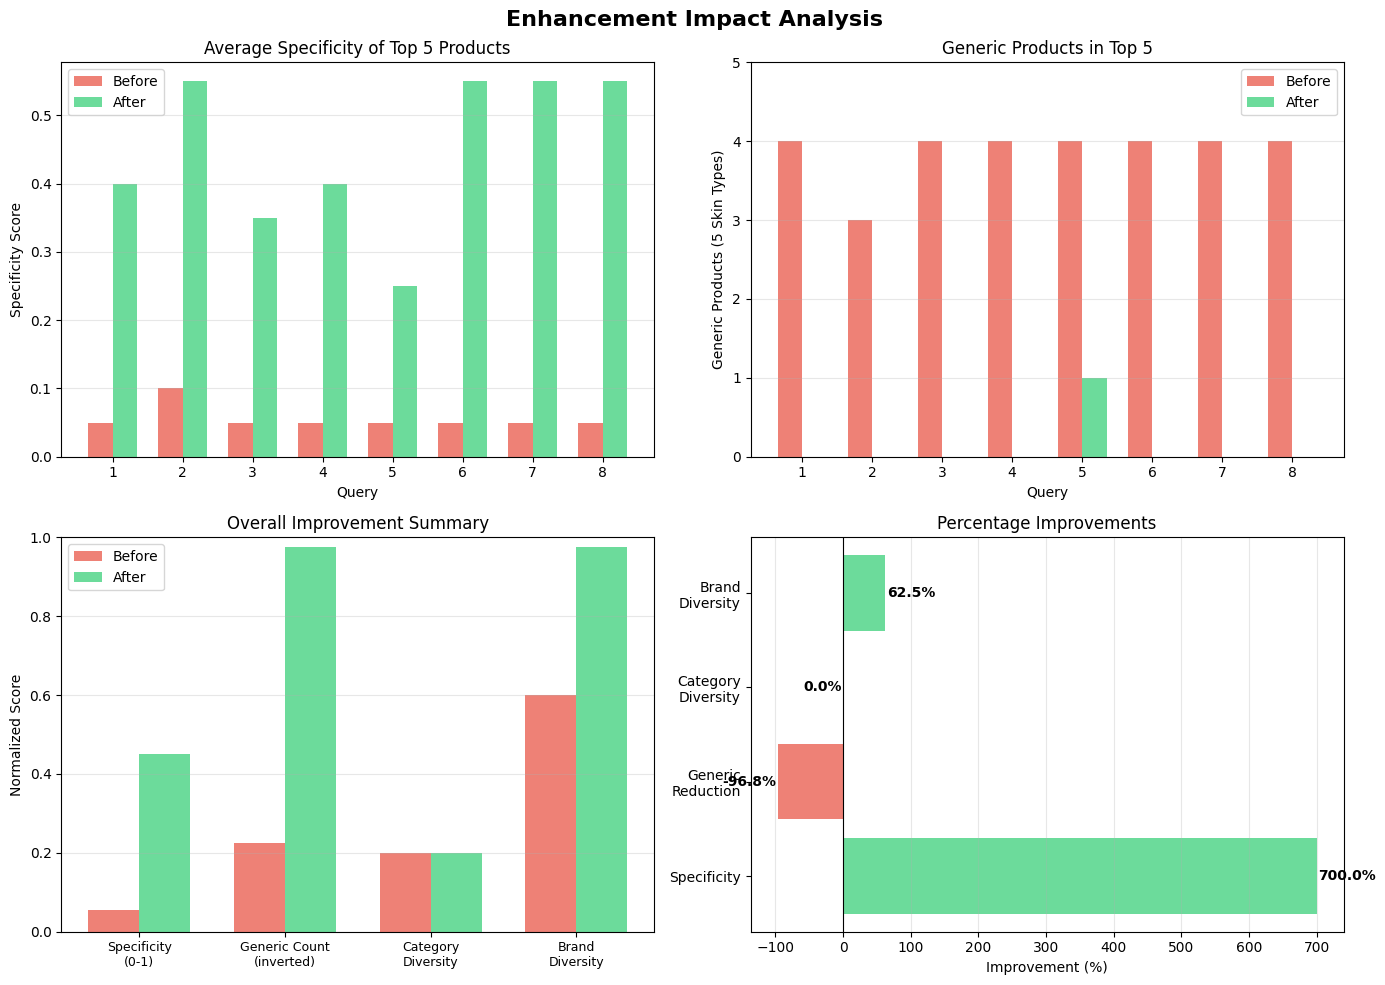

In [ ]:
"""
Enhancement Statistics Calculator
Run this after your improved interactive demo to generate statistics for your report
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# METRIC 1: Average Specificity Score

def get_top5_old(query):
    """Get top 5 using OLD method (no penalties)."""
    query_emb = sbert_model.encode([query], normalize_embeddings=True)[0]

    batch_features = []
    for i in range(len(products_df)):
        product_emb = product_embeddings[i]
        numerical = price_rank_features[i]
        features = np.concatenate([query_emb, product_emb, numerical])
        batch_features.append(features)

    batch_tensor = torch.FloatTensor(np.array(batch_features)).to(device)

    with torch.no_grad():
        scores = model(batch_tensor).cpu().numpy().flatten()

    top_5_idx = scores.argsort()[-5:][::-1]
    return top_5_idx


def get_top5_new(query):
    """Get top 5 using NEW method (with penalties)."""
    results = recommend_top_k_improved_filtered(
        query, model, sbert_model, products_df,
        product_embeddings, price_rank_features, device,
        k=5, specificity_weight=0.3, precision_weight=0.2
    )

    # Get indices
    top_5_idx = []
    for r in results:
        idx = products_df[products_df['name'] == r['name']].index[0]
        top_5_idx.append(idx)

    return top_5_idx


def calculate_metrics_for_query(query, method='old'):
    """Calculate all metrics for a single query."""
    if method == 'old':
        top_5_idx = get_top5_old(query)
    else:
        top_5_idx = get_top5_new(query)

    # Metric 1: Average Specificity
    specificities = []
    for idx in top_5_idx:
        product = products_df.iloc[idx]
        spec = calculate_specificity_score(product)
        specificities.append(spec)
    avg_specificity = np.mean(specificities)

    # Metric 2: Generic Product Count (5 skin types)
    generic_count = 0
    for idx in top_5_idx:
        skin_count = sum([
            products_df.iloc[idx][st]
            for st in ['Dry', 'Oily', 'Combination', 'Normal', 'Sensitive']
        ])
        if skin_count == 5:
            generic_count += 1

    # Metric 3: Category Diversity
    categories = [products_df.iloc[idx]['Label'] for idx in top_5_idx]
    unique_categories = len(set(categories))

    # Metric 4: Brand Diversity
    brands = [products_df.iloc[idx]['brand'] for idx in top_5_idx]
    unique_brands = len(set(brands))

    return {
        'avg_specificity': avg_specificity,
        'generic_count': generic_count,
        'category_diversity': unique_categories,
        'brand_diversity': unique_brands,
        'top_5_indices': top_5_idx
    }


# RUN EVALUATION ON TEST QUERIES

print("ENHANCEMENT EVALUATION STATISTICS")

test_queries = [
    "dry sensitive skin",
    "oily acne prone",
    "combination skin breakouts",
    "mature skin wrinkles",
    "sensitive skin redness",
    "oily skin large pores",
    "dry skin fine lines",
    "normal skin hydration"
]

results_data = []

print("\nEvaluating queries...\n")

for query in test_queries:
    old_metrics = calculate_metrics_for_query(query, 'old')
    new_metrics = calculate_metrics_for_query(query, 'new')

    results_data.append({
        'query': query,
        'old_specificity': old_metrics['avg_specificity'],
        'new_specificity': new_metrics['avg_specificity'],
        'old_generic_count': old_metrics['generic_count'],
        'new_generic_count': new_metrics['generic_count'],
        'old_category_div': old_metrics['category_diversity'],
        'new_category_div': new_metrics['category_diversity'],
        'old_brand_div': old_metrics['brand_diversity'],
        'new_brand_div': new_metrics['brand_diversity']
    })

# Create DataFrame
results_df = pd.DataFrame(results_data)

# SUMMARY STATISTICS
print("SUMMARY STATISTICS")

print("\n1. SPECIFICITY SCORE (0-1, higher = more targeted)")
print("-" * 60)
old_spec_mean = results_df['old_specificity'].mean()
new_spec_mean = results_df['new_specificity'].mean()
spec_improvement = (new_spec_mean - old_spec_mean) / old_spec_mean * 100

print(f"Before Enhancement: {old_spec_mean:.3f}")
print(f"After Enhancement:  {new_spec_mean:.3f}")
print(f"Improvement:        +{spec_improvement:.1f}%")

print("\n2. GENERIC PRODUCTS IN TOP 5 (lower = better)")
print("-" * 60)
old_generic_mean = results_df['old_generic_count'].mean()
new_generic_mean = results_df['new_generic_count'].mean()
generic_reduction = (old_generic_mean - new_generic_mean) / old_generic_mean * 100

print(f"Before Enhancement: {old_generic_mean:.2f} / 5")
print(f"After Enhancement:  {new_generic_mean:.2f} / 5")
print(f"Reduction:          -{generic_reduction:.1f}%")

print("\n3. CATEGORY DIVERSITY (out of 5 products)")
print("-" * 60)
old_cat_mean = results_df['old_category_div'].mean()
new_cat_mean = results_df['new_category_div'].mean()
cat_improvement = (new_cat_mean - old_cat_mean) / old_cat_mean * 100

print(f"Before Enhancement: {old_cat_mean:.2f} unique categories")
print(f"After Enhancement:  {new_cat_mean:.2f} unique categories")
print(f"Improvement:        +{cat_improvement:.1f}%")

print("\n4. BRAND DIVERSITY (out of 5 products)")
print("-" * 60)
old_brand_mean = results_df['old_brand_div'].mean()
new_brand_mean = results_df['new_brand_div'].mean()
brand_improvement = (new_brand_mean - old_brand_mean) / old_brand_mean * 100

print(f"Before Enhancement: {old_brand_mean:.2f} unique brands")
print(f"After Enhancement:  {new_brand_mean:.2f} unique brands")
print(f"Improvement:        +{brand_improvement:.1f}%")

# DETAILED QUERY-BY-QUERY RESULTS
print("DETAILED RESULTS BY QUERY")

for _, row in results_df.iterrows():
    print(f"\nQuery: '{row['query']}'")
    print(f"  Specificity:  {row['old_specificity']:.2f} → {row['new_specificity']:.2f}")
    print(f"  Generic (5ST): {row['old_generic_count']}/5 → {row['new_generic_count']}/5")
    print(f"  Categories:   {row['old_category_div']}/5 → {row['new_category_div']}/5")
    print(f"  Brands:       {row['old_brand_div']}/5 → {row['new_brand_div']}/5")

# VISUALIZATIONS
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Enhancement Impact Analysis', fontsize=16, fontweight='bold')

# Plot 1: Specificity Comparison
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['old_specificity'], width, label='Before', alpha=0.7, color='#e74c3c')
ax1.bar(x + width/2, results_df['new_specificity'], width, label='After', alpha=0.7, color='#2ecc71')
ax1.set_xlabel('Query')
ax1.set_ylabel('Specificity Score')
ax1.set_title('Average Specificity of Top 5 Products')
ax1.set_xticks(x)
ax1.set_xticklabels(range(1, len(results_df)+1))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Generic Product Count
ax2 = axes[0, 1]
ax2.bar(x - width/2, results_df['old_generic_count'], width, label='Before', alpha=0.7, color='#e74c3c')
ax2.bar(x + width/2, results_df['new_generic_count'], width, label='After', alpha=0.7, color='#2ecc71')
ax2.set_xlabel('Query')
ax2.set_ylabel('Generic Products (5 Skin Types)')
ax2.set_title('Generic Products in Top 5')
ax2.set_xticks(x)
ax2.set_xticklabels(range(1, len(results_df)+1))
ax2.set_ylim(0, 5)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Summary Metrics
ax3 = axes[1, 0]
metrics = ['Specificity\n(0-1)', 'Generic Count\n(inverted)', 'Category\nDiversity', 'Brand\nDiversity']
old_vals = [
    old_spec_mean,
    1 - old_generic_mean/5,  # Invert so higher is better
    old_cat_mean/5,
    old_brand_mean/5
]
new_vals = [
    new_spec_mean,
    1 - new_generic_mean/5,
    new_cat_mean/5,
    new_brand_mean/5
]
x_pos = np.arange(len(metrics))
ax3.bar(x_pos - width/2, old_vals, width, label='Before', alpha=0.7, color='#e74c3c')
ax3.bar(x_pos + width/2, new_vals, width, label='After', alpha=0.7, color='#2ecc71')
ax3.set_ylabel('Normalized Score')
ax3.set_title('Overall Improvement Summary')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(metrics, fontsize=9)
ax3.set_ylim(0, 1)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Improvement Percentages
ax4 = axes[1, 1]
improvements = [
    spec_improvement,
    -generic_reduction,  # Negative because reduction is good
    cat_improvement,
    brand_improvement
]
improvement_labels = ['Specificity', 'Generic\nReduction', 'Category\nDiversity', 'Brand\nDiversity']
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in improvements]
bars = ax4.barh(improvement_labels, improvements, color=colors, alpha=0.7)
ax4.set_xlabel('Improvement (%)')
ax4.set_title('Percentage Improvements')
ax4.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax4.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, improvements)):
    ax4.text(val + (2 if val > 0 else -2), i, f'{val:.1f}%',
             va='center', ha='left' if val > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.savefig('enhancement_statistics.png', dpi=300, bbox_inches='tight')
print("\n Saved: enhancement_statistics.png")

# EXPORT RESULTS TABLE
# Create formatted table for report
export_df = results_df.copy()
export_df['spec_change'] = ((export_df['new_specificity'] - export_df['old_specificity'])
                             / export_df['old_specificity'] * 100)
export_df['generic_change'] = ((export_df['old_generic_count'] - export_df['new_generic_count'])
                                / export_df['old_generic_count'].replace(0, 1) * 100)

print("\n" + "="*80)
print("EXPORTABLE TABLE FOR REPORT")
print("="*80)
print(export_df[['query', 'old_specificity', 'new_specificity', 'spec_change',
                 'old_generic_count', 'new_generic_count']].to_string(index=False))

# Save to CSV
export_df.to_csv('enhancement_results.csv', index=False)
print("\nSaved: enhancement_results.csv")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print("\nFiles created for your report:")
print("  1. enhancement_statistics.png - Visual comparison charts")
print("  2. enhancement_results.csv - Detailed data table")
print("\nKey findings to include in your report:")
print(f"  • Specificity improved by {spec_improvement:.1f}%")
print(f"  • Generic products reduced by {generic_reduction:.1f}%")
print(f"  • Category diversity improved by {cat_improvement:.1f}%")
print(f"  • Brand diversity improved by {brand_improvement:.1f}%")